## Problem statement

#### Overview

A gas canister explodes on a flat surface. Several small pieces of debris are sent flying in all directions. Where will they land?

#### Modelling assumptions

- The pieces can be modelled as free projectiles under uniform gravity $ g = 9.81 \ ms^{-2} $ with no air resistance.
- Each piece started from the same point, with randomly-varying initial speeds and angles.
- The speed $ u $ and angle $ \theta $ have (arbitrary) probability density functions written as $$ f_U(u) \ \ \text{and} \ \ f_{\Theta}(\theta), \ \ \text{for} \ \ 0 \leq u < \infty \ \ \text{and} \ \ 0 \leq \theta \leq \frac{\pi}{2}. $$
- The speed and the angle are independent.

#### Useful formulas

- The range of a projectile is given by $$ x = g(u, \theta) = \frac{u^2 \sin 2 \theta}{g}. $$

In [49]:
%matplotlib inline
%config InlineBackend.figure_formats = 'svg'

## Finding a distribution for the range $ x $

From the definition of the CDF, we have $ F_X(x) = P(X \leq x) = P(g(U, \Theta) \leq x) $. To work out the RHS, we integrate the joint PDF over the region of all $ u $ and $ \theta $ which gives $ X $ less than $ x $:

$$ F_X(x) = \int \limits_{(u, \ \theta): \ g(u, \ \theta) \ \leq \ x} f_{u, \ \theta}(u, \ \theta) \ \text{d} u \ \text{d} \theta. $$

where $ f_{u, \ \theta}(u, \ \theta) $ is the joint probability density function, which depends on the distributions we choose to model the random variables $ u $ and $ \theta $ as having. We will leave this as an arbitrary function for now.

In order to work out the region of integration, we will look at the contour plot for $ g(u, \ \theta) $.

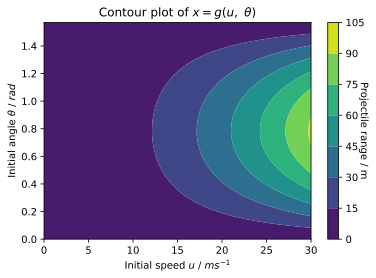

In [50]:
import numpy as np
from matplotlib import pyplot as plt

G = 9.81
g = lambda u, theta: (u ** 2 * np.sin(2 * theta)) / G

u_range = np.linspace(0, 30, 100)
theta_range = np.linspace(0, np.pi / 2, 100)

U, THETA = np.meshgrid(u_range, theta_range)
X = g(U, THETA)

contour_plot = plt.contourf(U, THETA, X)
color_bar = plt.colorbar(contour_plot)
color_bar.set_label('Projectile range / m', rotation=270)

plt.title(r'Contour plot of $ x = g(u, \ \theta) $')
plt.xlabel(r'Initial speed $ u $ / $ ms^{-1} $')
plt.ylabel(r'Initial angle $ \theta $ / $ rad $')
plt.show()

After seeing the contour plot, it will be easier to integrate over the region where $ x $ is *larger* than some value, then subtract it from 1. So our formula will use

$$ F_X(x) = 1 - \int \limits_{(u, \theta): \ g(u, \theta) \geq x} f_{u, \theta}(u, \theta)  \ \text{d} u \ \text{d} \theta $$

We now need to find the limits of integration. On the $ u $-axis, the region will be from the left-most peak of the contour, all the way up to infinity. This peak will always have $ \theta = \frac{pi}{4} $, which allows us to easily solve for value of $ u $ at the peak:

$$ x = \frac{u^2 \sin \left (2 \times \frac{\pi}{4} \right )}{g} \ \ \rightarrow \ \ u = \sqrt{gx}. $$

Next, for a given value of $ u $, we need the range of $ \theta $. This will be a closed interval between the lower and upper intersections with the contour. The lower limit and upper limit will be, respectively,

$$ \theta_{-} = \frac{1}{2} \sin^{-1} \frac{gx}{u^2} \ \ \text{and} \ \ \theta_{+} = \frac{1}{2} \cos^{-1} \frac{gx}{u^2}. $$

So our formula is

$$ F_X(x) = 1 - \int \limits_{\sqrt{gx}}^{\infty} \int \limits_{\frac{1}{2} \sin^{-1} \frac{gx}{u^2}}^{\frac{\pi}{2} - \frac{1}{2} \sin^{-1} \frac{gx}{u^2}} f_{u, \ \theta}(u, \ \theta) \ \text{d} \theta \ \text{d} u. $$

If we know $ f_{u, \ \theta}(u, \ \theta) $, then this is a formula which we can work with. Suppose that $ u $ uniformly distributed between $ 12 \text{ms}^{-1} $ and $ 32 \text{ms}^{-1} $, while $ \theta $ has a triangular distribution with a mode of $ \theta = 45 ^\circ $ and is zero at $ \theta = 0 $ and $ \theta = 90 ^\circ $.

Then we have the following marginal PDFs:

$$ f_U(u) = \begin{cases}
1/20, &  12 \leq u \leq 32, \\
0, & \text{otherwise}
\end{cases} \ \ \text{and} \ \
f_{\Theta}(\theta) = \begin{cases}
\frac{4 \pi - |4 \pi - 16 \theta |}{\pi ^2}, &  0 \leq \theta \leq \pi/2, \\
0, & \text{otherwise}
\end{cases} $$

Since $ u $ and $ \theta $ are independent, the joint PDF is simply their product:

$$ f_{U, \ \Theta} = f_U(u) \times f_{\Theta}(\theta) = 
\begin{cases}
\frac{4 \pi - |4 \pi - 16 \theta |}{20 \pi ^2}, &  12 \leq u \leq  32 \ \ \text{and} \ \ 0 \leq \theta \leq \pi/2, \\
0, & \text{otherwise}
\end{cases}. $$

This function is implemented now.

In [51]:
def f_u_theta(u: float, theta: float) -> float:
    '''
    Represents the joint PDF of theta and u.
    
    #### Arguments
    
    `u` (float): initial speed, in m/s
    `theta` (float): initial angle, in radians
    
    #### Returns
    
    float: the value of f_{u, theta}(u, theta)
    '''

    if 12 <= u <= 32 and 0 <= theta <= np.pi / 2:
        return (4 * np.pi - np.abs(4 * np.pi - 16 * theta)) / (20 * np.pi ** 2)
    else:
        return 0


We can now implement the CDF of $ x $:

In [52]:
from scipy.integrate import dblquad


X_MIN = 0
X_MAX = (32 ** 2) / G


def F_X(x: float) -> float:
    '''
    Represents the CDF of x.
    
    #### Arguments
    
    `x` (float): the projectile range, in m.
    
    #### Returns
    
    float: the value of F_X(x).
    '''

    if isinstance(x, np.ndarray):
        return np.array(list(map(F_X, x)))
    else:
        if X_MIN <= x <= X_MAX:

            f_theta_u = lambda theta, u: f_u_theta(u, theta)  # scipy's x and y are u and theta respectively
            theta_min = lambda u: 1/2 * np.arcsin(G * x / u ** 2)
            theta_max = lambda u: 1/2 * (np.pi - np.arcsin(G * x / u ** 2))
            
            fx, abserr = dblquad(f_theta_u, np.sqrt(G * x), np.Infinity, theta_min, theta_max)
            return 1 - fx

        else:
            return 1 if x >= X_MAX else 0

We can now plot the CDF of $ x $:

c:\Users\lnick\anaconda3\envs\AllLibs310\lib\site-packages\scipy\integrate\_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


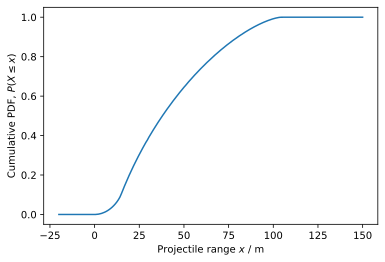

In [53]:
x_range = np.linspace(-20, 150, 200)

plt.plot(x_range, F_X(x_range))
plt.xlabel(r'Projectile range $ x $ / m')
plt.ylabel(r'Cumulative PDF, $ P(X \leq x) $')
plt.show()

Next, the PDF. Instead of differentiating this numerically, which would be slow and inaccurate due to the complexity of the function, we will manipulate algebraically first. We have

$$ f_X(x) = \frac{\mathrm{d} }{\mathrm{d} x} F_X(x) = - \frac{\mathrm{d} }{\mathrm{d} x} \int \limits_{\sqrt{gx}}^{\infty} \int \limits_{\frac{1}{2} \sin^{-1} \frac{gx}{u^2}}^{\frac{\pi}{2} - \frac{1}{2} \sin^{-1} \frac{gx}{u^2}} f_{u, \ \theta}(u, \ \theta) \ \text{d} \theta \ \text{d} u. $$

We will need to use the Leibniz rule twice to expand this. First, treat the inner integral as an arbitrary function $ F(x, u) $:

$$ \frac{\mathrm{d} }{\mathrm{d} x} \int \limits_{\sqrt{gx}}^{\infty} F(x, u) \ \text{d} u = -F(x, \sqrt{gx}) \times \frac{g}{2\sqrt{gx}} + \int \limits_{\sqrt{gx}}^{\infty} \frac{\partial F}{\partial x} \ \text{d} u $$

Now, work out the partial derivative of $ F $:

$$ \frac{\partial F}{\partial x} = \frac{\partial }{\partial x}  \int \limits_{\frac{1}{2} \sin^{-1} \frac{gx}{u^2}}^{\frac{\pi}{2} - \frac{1}{2} \sin^{-1} \frac{gx}{u^2}} f_{u, \ \theta}(u, \ \theta) \ \text{d} \theta = -\frac{g}{2\sqrt{u^4 - g^2 x^2}} \left ( f_{u, \ \theta}(u, \ \frac{\pi}{2} - \frac{1}{2} \sin^{-1} \frac{gx}{u^2}) + f_{u, \ \theta}(u, \ \frac{1}{2} \sin^{-1} \frac{gx}{u^2}) \right ) $$

Since $ F(x, \sqrt{gx}) $ = 0, we get our PDF as:

$$ f_X(x) =  \int \limits_{\sqrt{gx}}^{\infty} \frac{g}{2\sqrt{u^4 - g^2 x^2}} \left ( f_{u, \ \theta}(u, \ \frac{\pi}{2} - \frac{1}{2} \sin^{-1} \frac{gx}{u^2}) + f_{u, \ \theta}(u, \ \frac{1}{2} \sin^{-1} \frac{gx}{u^2})\right ) \ \text{d} u. $$

This function is implemented now.



In [68]:
from scipy.integrate import quad


def f_X(x: float) -> float:
    '''
    Represents the PDF of x.
    
    #### Arguments
    
    `x` (float): the projectile range, in m.
    
    #### Returns
    
    float: the value of f_X(x).
    '''    

    if isinstance(x, np.ndarray):
        return np.array(list(map(f_X, x)))
    else:
        if X_MIN < x < X_MAX:

            p1 = lambda u: f_u_theta(u, 1/2 * (np.pi - np.arcsin(G * x / u ** 2)))
            p2 = lambda u: f_u_theta(u, 1/2 * np.arcsin(G * x / u ** 2))
            p3 = lambda u: np.sqrt(u ** 4 - (G * x) ** 2)
            f_x_integrand = lambda u: (p1(u) + p2(u)) / p3(u)
            
            y, abserr = quad(f_x_integrand, np.sqrt(G * x), np.Infinity)
            return (G / 2) * y
        else:
            return 0

Now we can plot the PDF of $ x $:

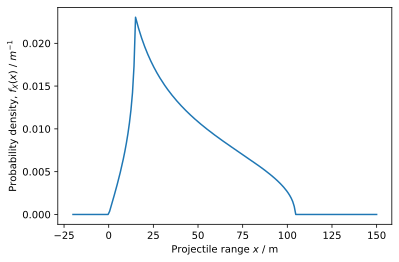

In [69]:
plt.plot(x_range, f_X(x_range))
plt.xlabel(r'Projectile range $ x $ / m')
plt.ylabel(r'Probability density, $ f_X(x) $ / $ m^{-1} $')
plt.show()

At first glance this seems reasonable - the PDF is zero at the minimum and maximum possible ranges, and there is a peak at 14.68 m, which corresponds to the projectiles landing with the minimum speed and optimal angle (which is $ \theta = \pi / 4 $). 

## Finding some properties of the distribution of $ x $

Let's check more carefully, by looking at the mean range, $ E[X] $. By LOTUS, we should get

$$ E[X] = \int \limits_{-\infty}^{\infty} \int \limits_{-\infty}^{\infty} g(u, \theta) \times f_{u, \ \theta}(u, \ \theta) \ \text{d} u \ \text{d} \theta $$

while from our PDF, we should get

$$ E[X] = \int \limits_{-\infty}^{\infty} x f_X(x) \ \text{d} x. $$

We can calculate both of these values explicitly and check they are equal:


In [72]:
def find_mean_range_lotus() -> float:
    '''
    Calculates E[X] using only the joint PDF and the function x = g(u, theta).
    
    #### Returns
    
    float: calculated mean range E[X].
    '''

    return dblquad(lambda u, theta: g(u, theta) * f_u_theta(u, theta), np.NINF, np.Inf, np.NINF, np.Inf)


def find_mean_range_pdf() -> float:
    '''
    Calculates E[X] using the PDF of x.
    
    #### Returns
    
    float: calculated mean range E[X].
    '''

    return quad(lambda x: x * f_X(x), np.NINF, np.Inf)


mean_lotus, lotus_abserr = find_mean_range_lotus()
mean_pdf, pdf_abserr = find_mean_range_pdf()


print(f'Mean range using LOTUS: {mean_lotus}, abserr: {lotus_abserr}')
print(f'Mean range using PDF: {mean_pdf}, abserr: {pdf_abserr}')
print(f'Difference: {abs(mean_lotus - mean_pdf)}, percent: {abs(mean_lotus - mean_pdf) / mean_pdf}')

Mean range using LOTUS: 42.74562743035101, abserr: 8.867871486017975e-07
Mean range using PDF: 42.745175446342685, abserr: 0.0015855548839312267
Difference: 0.0004519840083219151, percent: 1.0573918661049437e-05


C:\Users\lnick\AppData\Local\Temp/ipykernel_15668/281264653.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: x * f_X(x), np.NINF, np.Inf)


We can see that they are in fact equal - to within 3 d.p., which is within the margin of error reported when calculating from the PDF.